In [1]:
from pyspark.sql import SparkSession
import pyspark.sql.functions as F
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
spark_session = SparkSession.builder.appName('simple_statistics').getOrCreate()

Loading the data

In [3]:
df = spark_session.read.csv('data/googleplaystore.csv', header = True)

In [4]:
df.columns

['App',
 'Category',
 'Rating',
 'Reviews',
 'Size',
 'Installs',
 'Type',
 'Price',
 'Content Rating',
 'Genres',
 'Last Updated',
 'Current Ver',
 'Android Ver']

## Visualising the data

Firstly, I take a look at the data to familiarise with it. It seems that all the variables are categorical, even though I was expecting some of them to be numerical (like size, installs or rating). 

In [5]:
df.select('Category').distinct().collect()

[Row(Category='EVENTS'),
 Row(Category='COMICS'),
 Row(Category='SPORTS'),
 Row(Category='WEATHER'),
 Row(Category='VIDEO_PLAYERS'),
 Row(Category='AUTO_AND_VEHICLES'),
 Row(Category='PARENTING'),
 Row(Category='ENTERTAINMENT'),
 Row(Category='PERSONALIZATION'),
 Row(Category='HEALTH_AND_FITNESS'),
 Row(Category='TRAVEL_AND_LOCAL'),
 Row(Category='BOOKS_AND_REFERENCE'),
 Row(Category='FOOD_AND_DRINK'),
 Row(Category='PHOTOGRAPHY'),
 Row(Category='BUSINESS'),
 Row(Category='FAMILY'),
 Row(Category='SHOPPING'),
 Row(Category='HOUSE_AND_HOME'),
 Row(Category='GAME'),
 Row(Category='Face'),
 Row(Category='1.9'),
 Row(Category='EDUCATION'),
 Row(Category='PRODUCTIVITY'),
 Row(Category='TOOLS'),
 Row(Category='LIFESTYLE'),
 Row(Category='NEWS_AND_MAGAZINES'),
 Row(Category='MEDICAL'),
 Row(Category='COMMUNICATION'),
 Row(Category='MAPS_AND_NAVIGATION'),
 Row(Category='DATING'),
 Row(Category=' traffic jams'),
 Row(Category='LIBRARIES_AND_DEMO'),
 Row(Category='BEAUTY'),
 Row(Category='SOCIAL

In [6]:
# The rating is stored as a astring. Some non-numerical values
df.select('Rating').distinct().collect()

[Row(Rating='1.0'),
 Row(Rating='2.6'),
 Row(Rating='3.1'),
 Row(Rating='4.2'),
 Row(Rating='4.4'),
 Row(Rating='3.8'),
 Row(Rating='2.7'),
 Row(Rating='1.7'),
 Row(Rating='2.9'),
 Row(Rating='4.5'),
 Row(Rating='2.5'),
 Row(Rating='2.4'),
 Row(Rating='4.9'),
 Row(Rating='3.4'),
 Row(Rating='1.6'),
 Row(Rating='3.3'),
 Row(Rating='1.8'),
 Row(Rating='4.3'),
 Row(Rating='3.5'),
 Row(Rating='4.8'),
 Row(Rating=' navigation'),
 Row(Rating='Body'),
 Row(Rating='4.1'),
 Row(Rating='1.4'),
 Row(Rating='4.6'),
 Row(Rating='5.0'),
 Row(Rating='19'),
 Row(Rating='4.0'),
 Row(Rating='1.9'),
 Row(Rating='3.6'),
 Row(Rating='1.5'),
 Row(Rating='2.8'),
 Row(Rating='NaN'),
 Row(Rating='2.0'),
 Row(Rating='3.2'),
 Row(Rating='2.2'),
 Row(Rating='3.7'),
 Row(Rating='4.7'),
 Row(Rating='2.3'),
 Row(Rating='3.0'),
 Row(Rating='2.1'),
 Row(Rating='1.2'),
 Row(Rating='3.9')]

In [7]:
# This is a foreign key that points at another table
df.select('Reviews').collect()[0:10]

[Row(Reviews='159'),
 Row(Reviews='967'),
 Row(Reviews='87510'),
 Row(Reviews='215644'),
 Row(Reviews='967'),
 Row(Reviews='167'),
 Row(Reviews='178'),
 Row(Reviews='36815'),
 Row(Reviews='13791'),
 Row(Reviews='121')]

In [8]:
# As strings, with a suffix which indicates the unit
df.select('Size').collect()[0:10]

[Row(Size='19M'),
 Row(Size='14M'),
 Row(Size='8.7M'),
 Row(Size='25M'),
 Row(Size='2.8M'),
 Row(Size='5.6M'),
 Row(Size='19M'),
 Row(Size='29M'),
 Row(Size='33M'),
 Row(Size='3.1M')]

In [9]:
# Another categorical variable, instead of numerical, as I first expected
df.select('Installs').distinct().collect()

[Row(Installs='4.2'),
 Row(Installs='50,000+'),
 Row(Installs='4.4'),
 Row(Installs='100+'),
 Row(Installs='0'),
 Row(Installs='5,000,000+'),
 Row(Installs='100,000,000+'),
 Row(Installs='1,000,000,000+'),
 Row(Installs='1,000,000+'),
 Row(Installs='500,000,000+'),
 Row(Installs='10+'),
 Row(Installs='50+'),
 Row(Installs='5+'),
 Row(Installs='500+'),
 Row(Installs='1,000+'),
 Row(Installs='500,000+'),
 Row(Installs='0+'),
 Row(Installs='5,000+'),
 Row(Installs='10,000,000+'),
 Row(Installs='50,000,000+'),
 Row(Installs='100,000+'),
 Row(Installs='1+'),
 Row(Installs='Free'),
 Row(Installs='10,000+')]

In [10]:
df.select('Type').distinct().collect()

[Row(Type='0'),
 Row(Type='102248'),
 Row(Type='NaN'),
 Row(Type='Free'),
 Row(Type='Paid'),
 Row(Type='2509')]

In [11]:
# Another variable which I expected to be numerical
df.select('Price').distinct().collect()

[Row(Price='$1.29'),
 Row(Price='$19.99'),
 Row(Price='$0.99'),
 Row(Price='$4.59'),
 Row(Price='$400.00'),
 Row(Price='$89.99'),
 Row(Price='$24.99'),
 Row(Price='$1.96'),
 Row(Price='$39.99'),
 Row(Price='$12.99'),
 Row(Price='$8.99'),
 Row(Price='$11.99'),
 Row(Price='$14.99'),
 Row(Price='$25.99'),
 Row(Price='$3.04'),
 Row(Price='$15.46'),
 Row(Price='$2.50'),
 Row(Price='0'),
 Row(Price='5.0M'),
 Row(Price='$2.49'),
 Row(Price='$1.50'),
 Row(Price='$1.76'),
 Row(Price='$4.49'),
 Row(Price='$2.60'),
 Row(Price='$7.49'),
 Row(Price='$379.99'),
 Row(Price='$1.00'),
 Row(Price='$79.99'),
 Row(Price='$3.28'),
 Row(Price='$19.90'),
 Row(Price='$2.00'),
 Row(Price='$7.99'),
 Row(Price='$16.99'),
 Row(Price='$3.99'),
 Row(Price='$10.99'),
 Row(Price='$1.70'),
 Row(Price='$154.99'),
 Row(Price='$17.99'),
 Row(Price='$5.99'),
 Row(Price='$299.99'),
 Row(Price='$3.49'),
 Row(Price='$2.90'),
 Row(Price='$1.61'),
 Row(Price='$28.99'),
 Row(Price='$18.99'),
 Row(Price='$3.90'),
 Row(Price='$1.

In [12]:
df.select('Content rating').distinct().collect()

[Row(Content rating='Unrated'),
 Row(Content rating='Teen'),
 Row(Content rating='5,000,000+'),
 Row(Content rating=None),
 Row(Content rating='1,000,000+'),
 Row(Content rating='Mature 17+'),
 Row(Content rating='Everyone 10+'),
 Row(Content rating='Everyone'),
 Row(Content rating='Adults only 18+')]

In [13]:
df.select('Genres').distinct().collect()

[Row(Genres='Video Players & Editors;Creativity'),
 Row(Genres='Adventure;Action & Adventure'),
 Row(Genres='Education'),
 Row(Genres='Trivia'),
 Row(Genres='Art & Design;Action & Adventure'),
 Row(Genres='Auto & Vehicles'),
 Row(Genres='Travel & Local;Action & Adventure'),
 Row(Genres='Simulation;Action & Adventure'),
 Row(Genres='Education;Pretend Play'),
 Row(Genres='Tools;Education'),
 Row(Genres='Entertainment'),
 Row(Genres='Education;Education'),
 Row(Genres='Entertainment;Music & Video'),
 Row(Genres='Parenting;Brain Games'),
 Row(Genres='Simulation;Pretend Play'),
 Row(Genres='Arcade;Action & Adventure'),
 Row(Genres='Educational;Creativity'),
 Row(Genres='Arcade;Pretend Play'),
 Row(Genres='Casual;Music & Video'),
 Row(Genres='Adventure'),
 Row(Genres='Arcade'),
 Row(Genres='Books & Reference;Creativity'),
 Row(Genres='Education;Brain Games'),
 Row(Genres='Entertainment;Brain Games'),
 Row(Genres='Health & Fitness;Action & Adventure'),
 Row(Genres='Sports'),
 Row(Genres='Ente

In [14]:
df.select('Last updated').collect()[0:10]

[Row(Last updated='January 7, 2018'),
 Row(Last updated='January 15, 2018'),
 Row(Last updated='August 1, 2018'),
 Row(Last updated='June 8, 2018'),
 Row(Last updated='June 20, 2018'),
 Row(Last updated='March 26, 2017'),
 Row(Last updated='April 26, 2018'),
 Row(Last updated='June 14, 2018'),
 Row(Last updated='September 20, 2017'),
 Row(Last updated='July 3, 2018')]

In [15]:
df.select('Current ver').collect()[0:10]

[Row(Current ver='1.0.0'),
 Row(Current ver='2.0.0'),
 Row(Current ver='1.2.4'),
 Row(Current ver='Varies with device'),
 Row(Current ver='1.1'),
 Row(Current ver='1.0'),
 Row(Current ver='1.1'),
 Row(Current ver='6.1.61.1'),
 Row(Current ver='2.9.2'),
 Row(Current ver='2.8')]

In [16]:
df.select('Android ver').distinct().collect()

[Row(Android ver='2.0.1 and up'),
 Row(Android ver='4.1 and up'),
 Row(Android ver='4.4 and up'),
 Row(Android ver='2.3.3 and up'),
 Row(Android ver='5.0 - 6.0'),
 Row(Android ver=None),
 Row(Android ver='4.0.3 and up'),
 Row(Android ver='4.1 - 7.1.1'),
 Row(Android ver='7.0 - 7.1.1'),
 Row(Android ver='4.0.3 - 7.1.1'),
 Row(Android ver='7.0 and up'),
 Row(Android ver='7.1 and up'),
 Row(Android ver='3.2 and up'),
 Row(Android ver='Health & Fitness'),
 Row(Android ver='1.0 and up'),
 Row(Android ver='6.0 and up'),
 Row(Android ver='4.3 and up'),
 Row(Android ver='5.1 and up'),
 Row(Android ver='3.0 and up'),
 Row(Android ver='3.1 and up'),
 Row(Android ver='4.0 and up'),
 Row(Android ver='1.6 and up'),
 Row(Android ver='2.1 and up'),
 Row(Android ver='2.0 and up'),
 Row(Android ver='4.4W and up'),
 Row(Android ver='NaN'),
 Row(Android ver='Varies with device'),
 Row(Android ver='1.5 and up'),
 Row(Android ver='2.2 and up'),
 Row(Android ver='5.0 and up'),
 Row(Android ver='2.2 - 7.1.1'

## Visualising proportion of missing values per column

The only columns with missing values are `Content Rating`, `Current Ver` and `Android Ver`. However. the proportion of missing values is very low. 

In [17]:
total = df.count()
for c in df.columns:
    print(c)
    missing = df.filter(F.col(c).isNull()).count()
    print(str(missing/total*100) + '%')
    
    print(' ')

App
0.0%
 
Category
0.0%
 
Rating
0.0%
 
Reviews
0.0%
 
Size
0.0%
 
Installs
0.0%
 
Type
0.0%
 
Price
0.0%
 
Content Rating
0.009224241306152568%
 
Genres
0.0%
 
Last Updated
0.0%
 
Current Ver
0.009224241306152568%
 
Android Ver
0.009224241306152568%
 


## Frequency tables for the categorical variables

I am doing this only for the columns that I consider to be categorical in this dataset: `Category`, `Rating`, `Installs`, `Type`, `Content Rating`, `Genres` and `Android ver`.

In [18]:
for c in ['Category', 'Rating', 'Installs', 'Type', 'Content Rating', 'Android Ver']:
    df.groupby(c).count().sort(F.col('count').desc()).show(50)

+-------------------+-----+
|           Category|count|
+-------------------+-----+
|             FAMILY| 1972|
|               GAME| 1144|
|              TOOLS|  843|
|            MEDICAL|  463|
|           BUSINESS|  460|
|       PRODUCTIVITY|  424|
|    PERSONALIZATION|  392|
|      COMMUNICATION|  387|
|             SPORTS|  384|
|          LIFESTYLE|  382|
|            FINANCE|  366|
| HEALTH_AND_FITNESS|  340|
|        PHOTOGRAPHY|  335|
|             SOCIAL|  295|
| NEWS_AND_MAGAZINES|  283|
|           SHOPPING|  260|
|   TRAVEL_AND_LOCAL|  258|
|             DATING|  234|
|BOOKS_AND_REFERENCE|  231|
|      VIDEO_PLAYERS|  175|
|          EDUCATION|  156|
|      ENTERTAINMENT|  149|
|MAPS_AND_NAVIGATION|  136|
|     FOOD_AND_DRINK|  127|
|     HOUSE_AND_HOME|   88|
| LIBRARIES_AND_DEMO|   85|
|  AUTO_AND_VEHICLES|   85|
|            WEATHER|   82|
|     ART_AND_DESIGN|   65|
|             EVENTS|   64|
|             COMICS|   60|
|          PARENTING|   60|
|             BEAUTY

The `Genres` column has to be split by `;`:

In [19]:
df.select(
    F.posexplode(F.split('Genres', ';')).alias('pos', 'val')
).groupby('val').count().sort(F.col('count').desc()).show(100)

+--------------------+-----+
|                 val|count|
+--------------------+-----+
|               Tools|  843|
|           Education|  761|
|       Entertainment|  667|
|             Medical|  463|
|            Business|  460|
|        Productivity|  424|
|              Sports|  402|
|     Personalization|  392|
|       Communication|  388|
|           Lifestyle|  383|
|              Action|  382|
|             Finance|  366|
|    Health & Fitness|  342|
|         Photography|  335|
|              Social|  295|
|    News & Magazines|  283|
|              Casual|  270|
|            Shopping|  260|
|      Travel & Local|  258|
|              Arcade|  237|
|              Dating|  234|
|   Books & Reference|  234|
|          Simulation|  218|
|Video Players & E...|  178|
|              Puzzle|  167|
|  Action & Adventure|  138|
|   Maps & Navigation|  136|
|        Food & Drink|  127|
|        Role Playing|  123|
|              Racing|  119|
|         Educational|  112|
|            S

## Statistics for the numerical variables

This step requires that the values are parsed and transformed into numerical values. I will do this step for `Rating`, `Reviews` and `Size`.

In [20]:
rating = df.select(df.Rating.cast('float').alias('Rating'))\
           .where(F.col('Rating').isNotNull())\
           .where(F.isnan(F.col('Rating')) == False)
mean = rating.select(F.mean(rating.Rating).alias('mean')).collect()[0]['mean']
std = rating.select(F.stddev(rating.Rating).alias('mean')).collect()[0]['mean']
min_ = rating.select(F.min(rating.Rating).alias('min')).collect()[0]['min']
max_ = rating.select(F.max(rating.Rating).alias('max')).collect()[0]['max']
print('Rating: mean = ' + str(mean) + ', std = ' + str(std))
print('min = ' + str(min_) + ', max = ' + str(max_))

Rating: mean = 4.193315532712839, std = 0.537484445283305
min = 1.0, max = 19.0


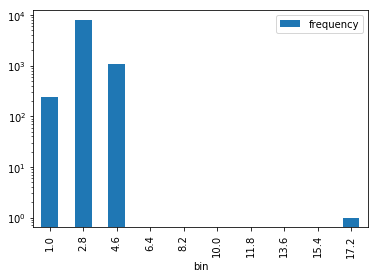

In [21]:
rating_histogram = rating.select('Rating').rdd.flatMap(lambda x: x).histogram(10)

pd.DataFrame(
    list(zip(*rating_histogram)), 
    columns=['bin', 'frequency']
).set_index(
    'bin'
).plot(kind = 'bar', logy = True);

In [22]:
reviews = df.select(df.Reviews.cast('float').alias('Reviews'))\
            .where(F.col('Reviews').isNotNull())\
            .where(F.isnan(F.col('Reviews')) == False)
mean = reviews.select(F.mean(reviews.Reviews).alias('mean')).collect()[0]['mean']
std = reviews.select(F.stddev(reviews.Reviews).alias('mean')).collect()[0]['mean']
min_ = reviews.select(F.min(reviews.Reviews).alias('min')).collect()[0]['min']
max_ = reviews.select(F.max(reviews.Reviews).alias('max')).collect()[0]['max']
print('Reviews: mean = ' + str(mean) + ', std = ' + str(std))
print('min = ' + str(min_) + ', max = ' + str(max_))

Reviews: mean = 444225.1921018638, std = 2928025.822397924
min = 0.0, max = 78158304.0


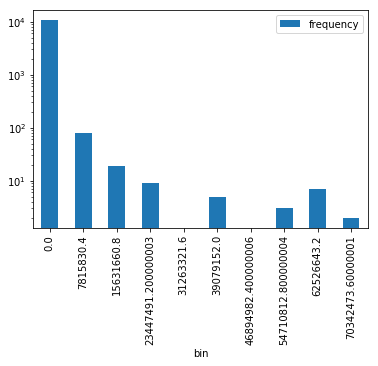

In [23]:
reviews_histogram = reviews.select('Reviews').rdd.flatMap(lambda x: x).histogram(10)

pd.DataFrame(
    list(zip(*reviews_histogram)), 
    columns=['bin', 'frequency']
).set_index(
    'bin'
).plot(kind = 'bar', logy = True);

In [24]:
# In the case of the size, I've observed that the first rows end in M. Are there any other characters?
df.select('Size').filter(~df.Size.rlike('[M]')).show()

+------------------+
|              Size|
+------------------+
|Varies with device|
|Varies with device|
|Varies with device|
|              201k|
|Varies with device|
|Varies with device|
|Varies with device|
|Varies with device|
|Varies with device|
|Varies with device|
|Varies with device|
|Varies with device|
|Varies with device|
|Varies with device|
|Varies with device|
|Varies with device|
|Varies with device|
|Varies with device|
|Varies with device|
|Varies with device|
+------------------+
only showing top 20 rows



In [25]:
df.select('Size').filter(df.Size != 'Varies with device').filter(~df.Size.rlike('[Mk]')).show()

+------------------+
|              Size|
+------------------+
|HEALTH_AND_FITNESS|
|            1,000+|
+------------------+



In [26]:
# Filtering and transforming to numbers
filter_strings = ['Varies with device', 'HEALTH_AND_FITNESS', '1,000+']

char_replace = F.udf(lambda x: x.replace('M', '').replace('K', ''))

sizes = df.select('Size') \
          .filter(df.Size.isin(filter_strings) == False) \
          .withColumn('Size', char_replace('Size').cast('float'))
mean = sizes.select(F.mean(sizes.Size).alias('mean')).collect()[0]['mean']
std = sizes.select(F.stddev(sizes.Size).alias('mean')).collect()[0]['mean']
min_ = sizes.select(F.min(sizes.Size).alias('min')).collect()[0]['min']
max_ = sizes.select(F.max(sizes.Size).alias('max')).collect()[0]['max']
print('Sizes: mean = ' + str(mean) + ', std = ' + str(std))
print('min = ' + str(min_) + ', max = ' + str(max_))

Sizes: mean = 22.27249660125187, std = 22.629226354052612
min = 1.0, max = 100.0


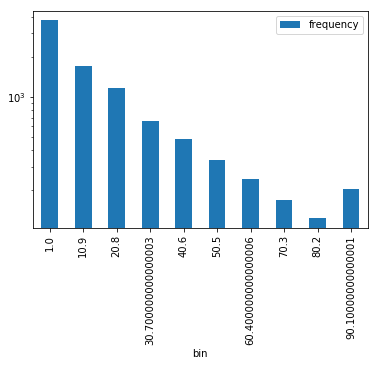

In [27]:
sizes_histogram = sizes.select('Size').rdd.flatMap(lambda x: x).histogram(10)

pd.DataFrame(
    list(zip(*sizes_histogram)), 
    columns=['bin', 'frequency']
).set_index(
    'bin'
).plot(kind = 'bar', logy = True);

How would the rating histograms be if we grouped by `Category`? (only the 5 most frequent ones).

Categories are filtered by means of a **broadcast variable**, that is, a read-only variable that is shared across all the nodes in the cluster. 

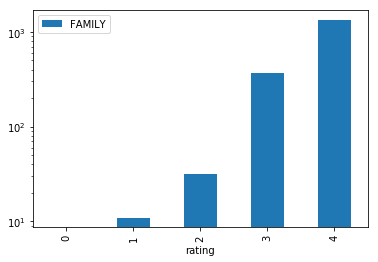

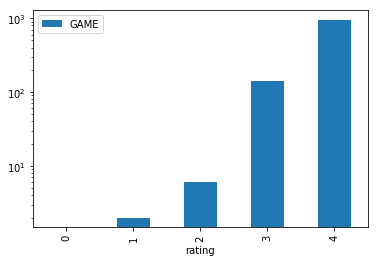

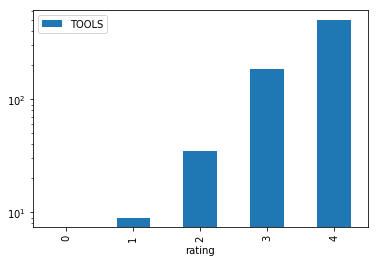

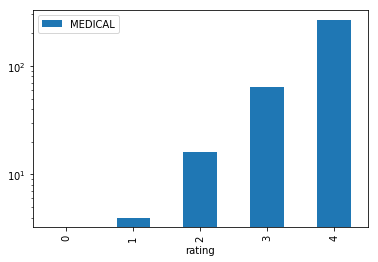

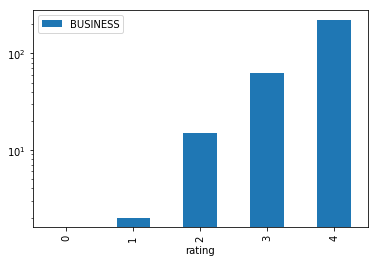

In [28]:
categories = spark_session.sparkContext.broadcast(['FAMILY', 'GAME', 'TOOLS', 'MEDICAL', 'BUSINESS'])

df_rating = df.where(F.col('Category').isin(categories.value)) \
              .withColumn('Rating', df.Rating.cast('float')) \
              .where(F.col('Reviews').isNotNull()) \
              .where(F.isnan(F.col('Reviews')) == False) \
              .cache()

for c in categories.value:
    histogram = df_rating.filter(df.Category == c) \
                         .select('Rating') \
                         .rdd \
                         .flatMap(lambda x: x) \
                         .histogram([0, 1, 2, 3, 4, 5])

    pd.DataFrame(
        list(zip(*histogram)), 
        columns=['rating', c]
    ).set_index(
        'rating'
    ).plot(kind = 'bar', logy = True);



Finally, we demonstrate how to use an **accumulator** to count the number of values in the `Reviews` column that couldn't be transformed into a float. An accumulator is a read-write variable which value can only be read by the driver process (the main pyspark program). The only allowed write operations are increments. We can define our own accumulator types with different operations (any commutative and associative operation) by defining a subclass of AccumulatorParams. 

In [29]:
ac = spark_session.sparkContext.accumulator(0)

def ac_filter(x):
    try:
        if np.isnan(x):
            ac.add(1)
            return False
        else:
            return True
    except TypeError:
        ac.add(1)

df.select(df.Reviews.cast('float').alias('Reviews')).rdd.filter(ac_filter).collect()

print(ac.value)

3
